In [1]:
!nvidia-smi

Wed Mar  3 11:27:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!python --version


Python 3.7.10


In [3]:
!pip install -U fastai

     |████████████████████████████████| 194kB 22.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [4]:
from fastai.vision.all import *
from fastai import __version__

In [5]:
print(__version__)

2.2.7


In [6]:
#importing the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd drive/My\ Drive

/content/drive/My Drive


In [8]:
root_path = Path('.')
data_path = Path('surfacique_no_ss_class')
model_path = Path('Models')

In [9]:
size = 512
lr = defaults.lr
bs = 32

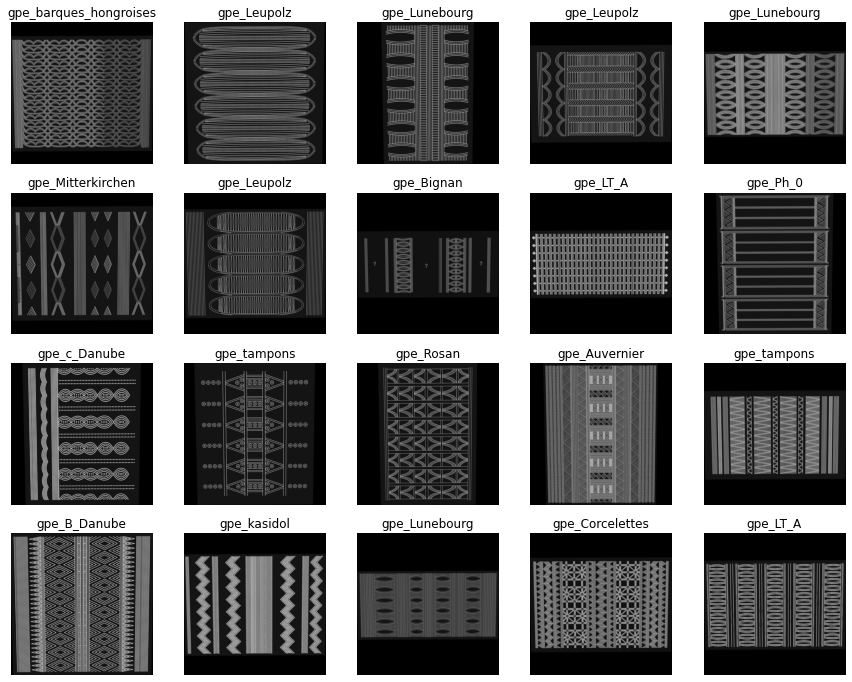

In [10]:
batch_transforms = aug_transforms(mult=1.0,
                                  do_flip=True,
                                  flip_vert=True,
                                  max_rotate=1.0, 
                                  min_zoom=1.0,
                                  max_zoom=1.0,
                                  max_lighting=0.2,
                                  max_warp=0.1,
                                  p_affine=0.75, 
                                  p_lighting=0.75,
                                  xtra_tfms=None,
                                  size=size,
                                  mode='bilinear',
                                  pad_mode='zeros',
                                  align_corners=True, 
                                  batch=True,
                                  min_scale=1.0)

db = DataBlock(blocks = (ImageBlock, CategoryBlock),
               get_items = get_image_files,
               splitter = RandomSplitter(valid_pct=0.2, seed=101),
               get_y = parent_label,
               item_tfms = Resize(size),
               batch_tfms = [*batch_transforms, Normalize()]
               )

data = db.dataloaders(data_path, bs=bs)
data.show_batch(max_n=20)



In [11]:
learner = cnn_learner(data,
                      resnet50,
                      metrics = error_rate,
                      pretrained = True,
                      wd_bn_bias = False,
                      loss_func = LabelSmoothingCrossEntropy(),
                      cbs = [BnFreeze,
                              SaveModelCallback(monitor='error_rate', fname='best_error'),
                              ShowGraphCallback],
                      model_dir = model_path
                      ).to_fp16()


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,3.939712,2.602265,0.542973,11:03
1,2.958557,2.332589,0.453994,01:37
2,2.475095,2.137360,0.397371,01:39
3,2.134588,2.068690,0.384227,01:40
4,1.898802,1.912132,0.332659,01:41
5,1.744114,1.870113,0.341759,01:41
6,1.607462,1.846465,0.319515,01:41
7,1.509629,1.853182,0.316481,01:41
8,1.439626,1.819223,0.312437,01:41
9,1.392610,1.823799,0.310415,01:41


Better model found at epoch 0 with error_rate value: 0.5429726839065552.


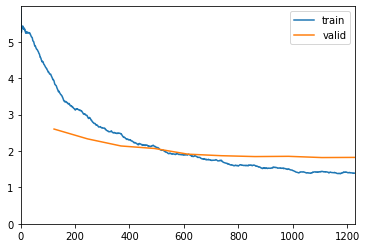

Better model found at epoch 1 with error_rate value: 0.45399394631385803.
Better model found at epoch 2 with error_rate value: 0.3973710834980011.
Better model found at epoch 3 with error_rate value: 0.3842265009880066.
Better model found at epoch 4 with error_rate value: 0.3326592445373535.
Better model found at epoch 6 with error_rate value: 0.319514662027359.
Better model found at epoch 7 with error_rate value: 0.3164812922477722.
Better model found at epoch 8 with error_rate value: 0.3124368190765381.
Better model found at epoch 9 with error_rate value: 0.31041455268859863.


In [12]:
learner.fit_one_cycle(n_epoch=10, lr_max= lr)

In [13]:
learner.save('stage-1')

Path('Models/stage-1.pth')

SuggestedLRs(lr_min=1.0964781722577755e-07, lr_steep=6.309573450380412e-07)

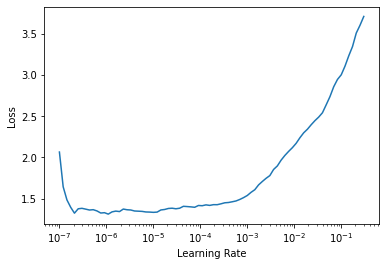

In [14]:
learner.unfreeze()
learner.lr_find()

In [15]:
lr = 1e-4

epoch,train_loss,valid_loss,error_rate,time
0,1.371021,1.783525,0.309403,02:01
1,1.384299,1.806111,0.314459,02:01
2,1.391052,1.849886,0.329626,02:01
3,1.383055,1.880794,0.312437,02:01
4,1.432309,1.883740,0.326593,02:01
5,1.420678,1.866776,0.311426,02:01
6,1.407555,1.929863,0.351871,02:01
7,1.389881,1.895007,0.317492,02:01
8,1.310395,1.793731,0.291203,02:01
9,1.241756,1.789560,0.293225,02:01


Better model found at epoch 0 with error_rate value: 0.3094034492969513.


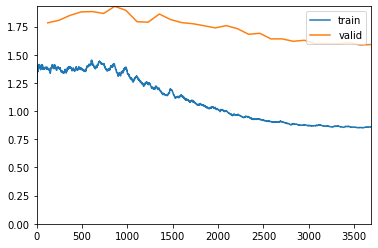

Better model found at epoch 8 with error_rate value: 0.29120323061943054.
Better model found at epoch 11 with error_rate value: 0.2770475149154663.
Better model found at epoch 14 with error_rate value: 0.260869562625885.
Better model found at epoch 19 with error_rate value: 0.25884732604026794.
Better model found at epoch 22 with error_rate value: 0.2537917196750641.
Better model found at epoch 23 with error_rate value: 0.25278058648109436.
Better model found at epoch 24 with error_rate value: 0.23862487077713013.


In [16]:
learner.fit_one_cycle(n_epoch=30, lr_max= lr)

In [17]:
learner.save('stage-2')

Path('Models/stage-2.pth')

In [18]:
learner.export('Models/surfacique_seulement.pkl')